<a href="https://colab.research.google.com/github/YoshifumiMiyagi/KD_ML/blob/main/IP2_add76.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import codecs
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

SEED=42

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
add = pd.read_csv("/content/drive/MyDrive/Dr.Miyagi_R6_5_31_DB_1_add.csv", encoding='cp932')

In [6]:
raw3_2 = add.loc[:,['Age', 'Length', 'Weight', 'sex', '5th Criteria count',
       'Treat day', 'preWBC_1',  'preNetro',  'pre_Lym', 'preCRP_1',
       'prePlt','preTbil','preAST', 'preALT', 'preNa', 'preIgG']]
raw3_2.columns = ['Age', 'Length', 'Weight', 'sex', 'Criteria',
       'Treat day', 'WBC',  'Neutro',  'Lym', 'CRP',
       'Plt','Tbil','AST', 'ALT', 'Na', 'IgG']
raw3_2['sex'] = raw3_2['sex'].replace('F',0).replace('M',1).replace('female',0).replace('male',1)
Dx_2 = raw3_2
Dy_2 = add.loc[:,"Response"]

In [7]:
imp_mean = IterativeImputer(random_state=SEED)
A= imp_mean.fit_transform(Dx_2)
A= pd.DataFrame(A)
A.index = Dx_2.index
A.columns = Dx_2.columns

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

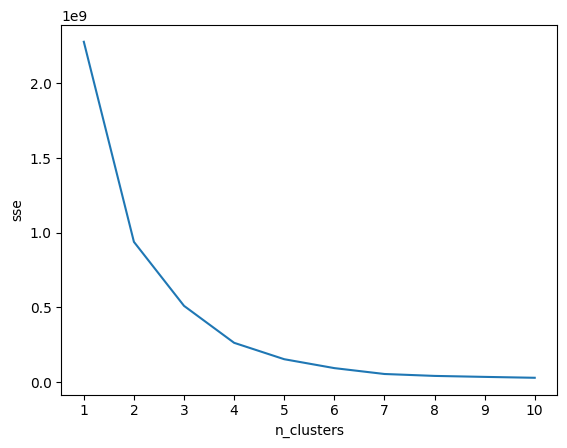

In [8]:
from sklearn.cluster import KMeans

SSE = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(A)
  SSE.append(kmeans.inertia_)


plt.plot(range(1, 11), SSE)

plt.xlabel('n_clusters')
plt.ylabel('sse')
plt.xticks(range(1,11,1))

plt.show()

In [9]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters = 3).fit(A)
clusters = kmeans_model.labels_

k=3
for i in range(k):
    num = list(clusters).count(i)
    print(f'Cluster {i}: n = {num}')

Cluster 0: n = 40
Cluster 1: n = 7
Cluster 2: n = 29


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


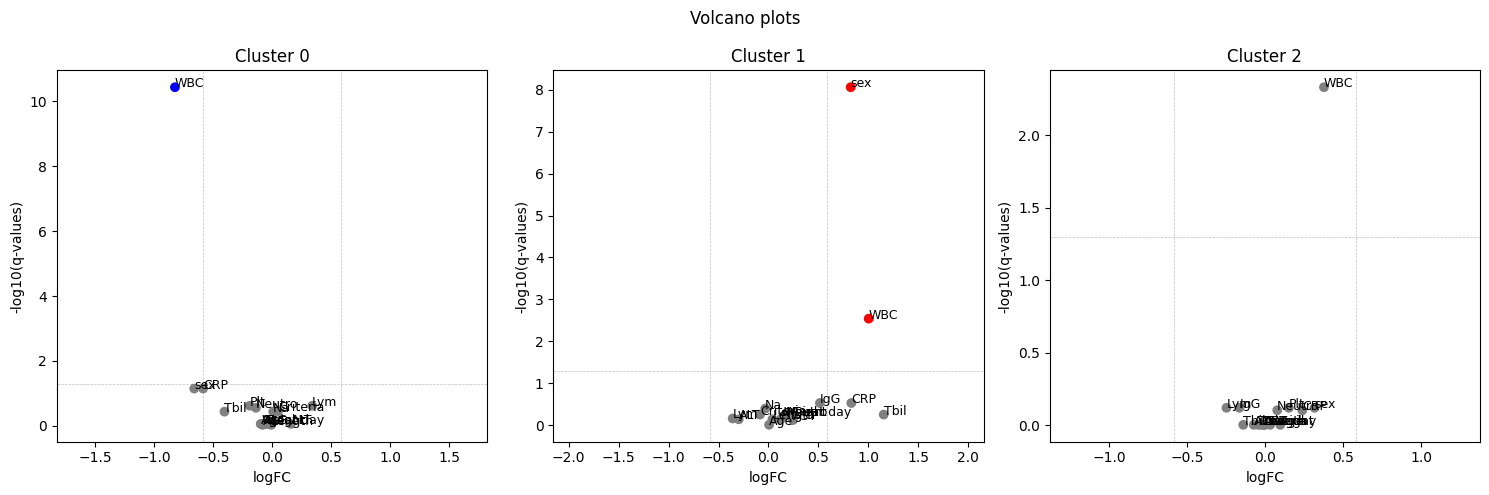

In [10]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_features_with_clusters = A.copy()
df_features_with_clusters['cluster'] = clusters
cols = A.columns

q_threshold = 0.05
fc_threshold = 1.5

fig = plt.figure(figsize=(15,5))

for i in range(k):
    p_values = []
    fcs = []

    for col in cols:

        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)


        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)


    q_values = multipletests(p_values, method='fdr_bh')[1]


    colors = []
    for col, q_value, fc in zip(cols, q_values, fcs):

        if q_value < q_threshold and fc > fc_threshold:
            colors.append('red')

        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('blue')

        else:
            colors.append('gray')

    ax = fig.add_subplot(1,3,i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1])
    ax.set_ylim(ax.get_ylim())


    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)


    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(cols):
        ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)

fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()

In [11]:
B = df_features_with_clusters.copy()
B['Group'] = Dy_2

In [12]:
B[B['cluster']==0]["Group"].value_counts(),B[B['cluster']==1]["Group"].value_counts(),B[B['cluster']==2]["Group"].value_counts()

(Group
 1    28
 2    10
 4     2
 Name: count, dtype: int64,
 Group
 2    3
 1    2
 3    1
 4    1
 Name: count, dtype: int64,
 Group
 1    19
 2     8
 4     1
 3     1
 Name: count, dtype: int64)

Pythonでは2×2以上のFisherが不可。Rで対応。![IVIG.png](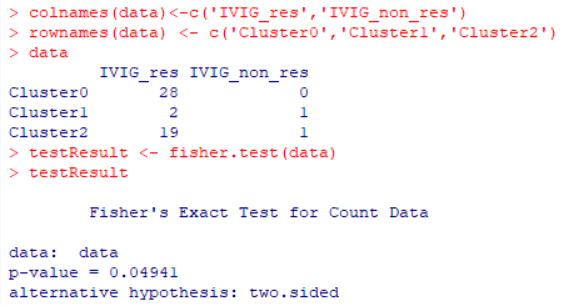![IVIG_Add_Coronary.png](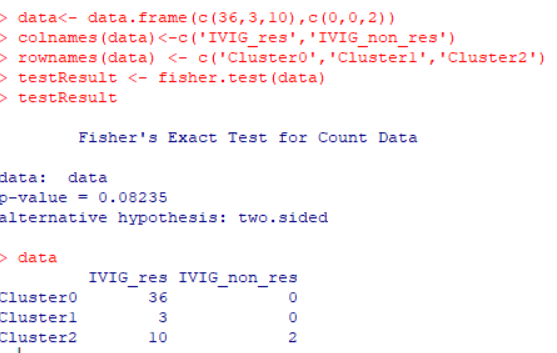![IVIG_PSL_Add_Coronary.png](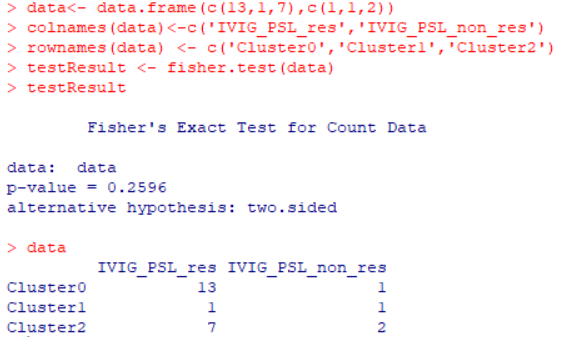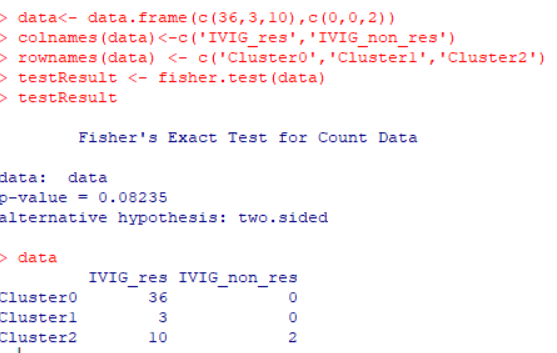)))

# IVIG responder vs non-responder

# IVIG+PSL responder vs non-responder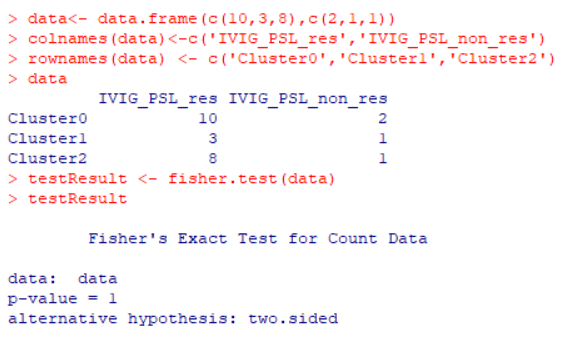

# 冠動脈データの追加

In [17]:
add.columns

Index(['ID', 'Age (y)', 'Age (m)', 'Age', 'Length', 'Weight', 'sex',
       '5th Criteria count', 'Onset date', 'Treat day', 'PSL_no_0,1',
       'IVIG-non-responder', 'Response', 'preWBC_1', 'postWBC_1', 'FC_WBC',
       'preNetro', 'post Netro', 'FC_Ne', 'pre_Lym', 'post_Lym', 'preCRP_1',
       'postCRP_1', 'FC_CRP', 'prePlt', 'postPlt', 'FC_Plt', 'preTbil',
       'postTbil', 'FC_Tbil', 'preAST', 'postAST', 'FC_AST', 'preALT',
       'postALT', 'FC_ALT', 'preNa', 'postNa', 'FC_Na', 'preIgG', 'postIgG',
       'FC_IgG', 'preBNP', 'postBNP', 'PrePCT', 'D_dimer', 'HrBeta', 'HrCre',
       'RCA_mm', 'RCA_z', 'LMT_mm', 'LMT_z', 'LAD_mm', 'LAD_z', 'LCX_mm',
       'LCX_z', 'CA_max_diameter', 'CA_max_z'],
      dtype='object')

In [18]:
raw3_2 = add.loc[:,['Age', 'Length', 'Weight', 'sex', '5th Criteria count',
       'Treat day', 'preWBC_1',  'preNetro',  'pre_Lym', 'preCRP_1',
       'prePlt','preTbil','preAST', 'preALT', 'preNa', 'preIgG',
                    'preBNP', 'PrePCT', 'D_dimer', 'HrBeta', 'HrCre',
       'RCA_mm', 'RCA_z', 'LMT_mm', 'LMT_z', 'LAD_mm', 'LAD_z', 'LCX_mm',
       'LCX_z', 'CA_max_diameter', 'CA_max_z']]
raw3_2.columns = ['Age', 'Length', 'Weight', 'sex', 'Criteria',
       'Treat day', 'WBC',  'Neutro',  'Lym', 'CRP',
       'Plt','Tbil','AST', 'ALT', 'Na', 'IgG',
                  'BNP', 'PCT', 'D_dimer', 'HrBeta', 'HrCre',
       'RCA_mm', 'RCA_z', 'LMT_mm', 'LMT_z', 'LAD_mm', 'LAD_z', 'LCX_mm',
       'LCX_z', 'CA_max_diameter', 'CA_max_z']
raw3_2['sex'] = raw3_2['sex'].replace('F',0).replace('M',1).replace('female',0).replace('male',1)
Dx_2 = raw3_2
Dy_2 = add.loc[:,"Response"]

In [19]:
imp_mean = IterativeImputer(random_state=SEED)
A= imp_mean.fit_transform(Dx_2)
A= pd.DataFrame(A)
A.index = Dx_2.index
A.columns = Dx_2.columns

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

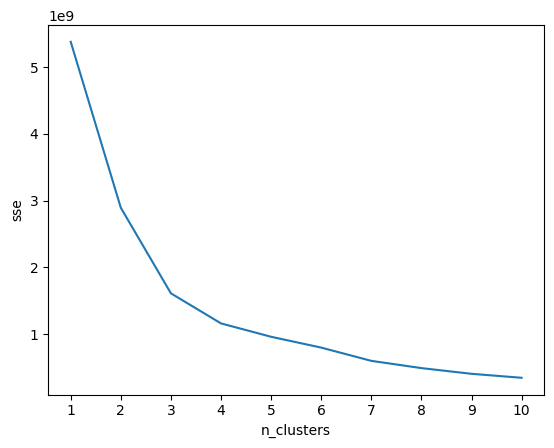

In [20]:
from sklearn.cluster import KMeans

SSE = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(A)
  SSE.append(kmeans.inertia_)


plt.plot(range(1, 11), SSE)

plt.xlabel('n_clusters')
plt.ylabel('sse')
plt.xticks(range(1,11,1))

plt.show()

In [21]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters = 3).fit(A)
clusters = kmeans_model.labels_

k=3
for i in range(k):
    num = list(clusters).count(i)
    print(f'Cluster {i}: n = {num}')

Cluster 0: n = 50
Cluster 1: n = 5
Cluster 2: n = 21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


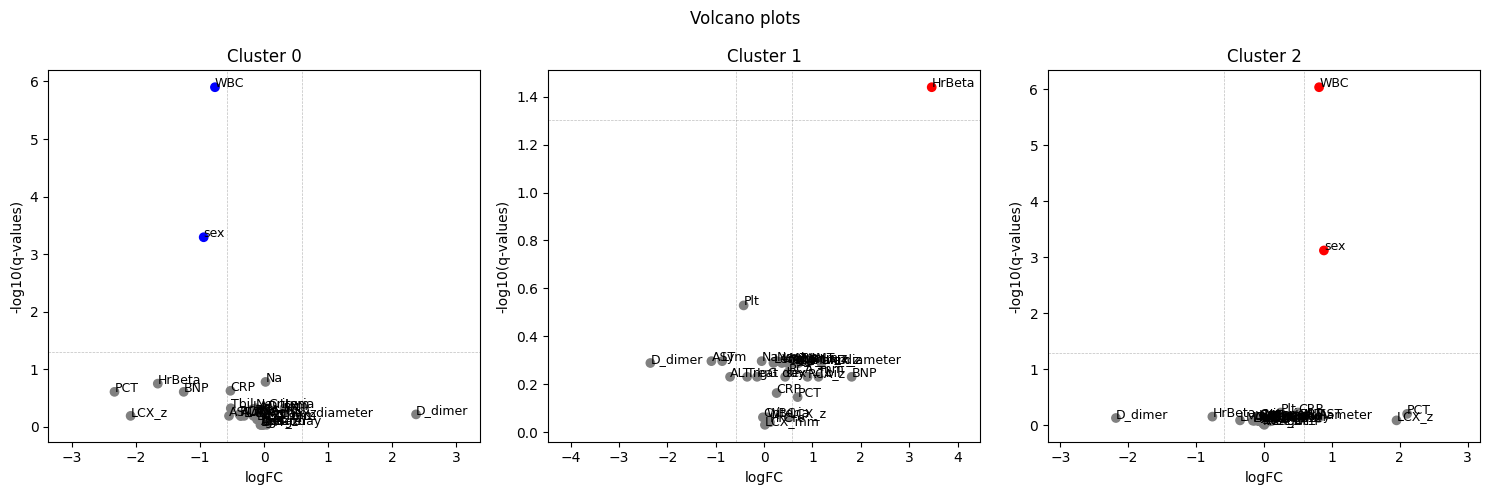

In [22]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_features_with_clusters = A.copy()
df_features_with_clusters['cluster'] = clusters
cols = A.columns

q_threshold = 0.05
fc_threshold = 1.5

fig = plt.figure(figsize=(15,5))

for i in range(k):
    p_values = []
    fcs = []

    for col in cols:

        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)


        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)


    q_values = multipletests(p_values, method='fdr_bh')[1]


    colors = []
    for col, q_value, fc in zip(cols, q_values, fcs):

        if q_value < q_threshold and fc > fc_threshold:
            colors.append('red')

        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('blue')

        else:
            colors.append('gray')

    ax = fig.add_subplot(1,3,i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1])
    ax.set_ylim(ax.get_ylim())


    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)


    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(cols):
        ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)

fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()

In [23]:
B = df_features_with_clusters.copy()
B['Group'] = Dy_2

In [24]:
B[B['cluster']==0]["Group"].value_counts(),B[B['cluster']==1]["Group"].value_counts(),B[B['cluster']==2]["Group"].value_counts()

(Group
 1    36
 2    13
 4     1
 Name: count, dtype: int64,
 Group
 1    3
 4    1
 2    1
 Name: count, dtype: int64,
 Group
 1    10
 2     7
 3     2
 4     2
 Name: count, dtype: int64)

IVIG (responder vs non-responder)



IVIG+PSL (responder vs non-responder)

# RのFisher testで有意差なし